<a href="https://colab.research.google.com/github/Aynahd/Y24/blob/main/stanfordGuy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
#from torchvision import summary
import torchvision
from torch.utils.data import DataLoader

In [2]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [3]:
from torchsummary import summary

In [4]:
!pip install torchsummary

In [5]:
class SimpleCNNForMNIST(nn.Module):
  def __init__(self):
    super(SimpleCNNForMNIST, self).__init__()
    #first conv layer, input grayscale, 32 output channels.
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)

    #first conv layer, input 32 input, 64 output
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    #pooling
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    #dropout1
    self.dropout1 = nn.Dropout(0.25)
    #flatten
    self.flatten = nn.Flatten()
    #fully connected
    self.fc1 = nn.Linear(64*14*14, 128)
    #droput 2
    self.dropout2 = nn.Dropout(0.50)
    #fc 2
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
      x = F.relu(self.conv1(x))
      x = self.pool(F.relu(self.conv2(x)))
      x = self.dropout1(x)
      x = self.flatten(x)
      x = F.relu(self.fc1(x))
      x = self.dropout2(x)
      x = self.fc2(x)
      return x




In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNNForMNIST().to(device)
summary = summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
           Dropout-4           [-1, 64, 14, 14]               0
           Flatten-5                [-1, 12544]               0
            Linear-6                  [-1, 128]       1,605,760
           Dropout-7                  [-1, 128]               0
            Linear-8                   [-1, 10]           1,290
Total params: 1,625,866
Trainable params: 1,625,866
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.86
Params size (MB): 6.20
Estimated Total Size (MB): 7.07
----------------------------------------------------------------


In [7]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms)



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:11<00:00, 897kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:06<00:00, 241kB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.1MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [8]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



tensor(-1.) tensor(1.)


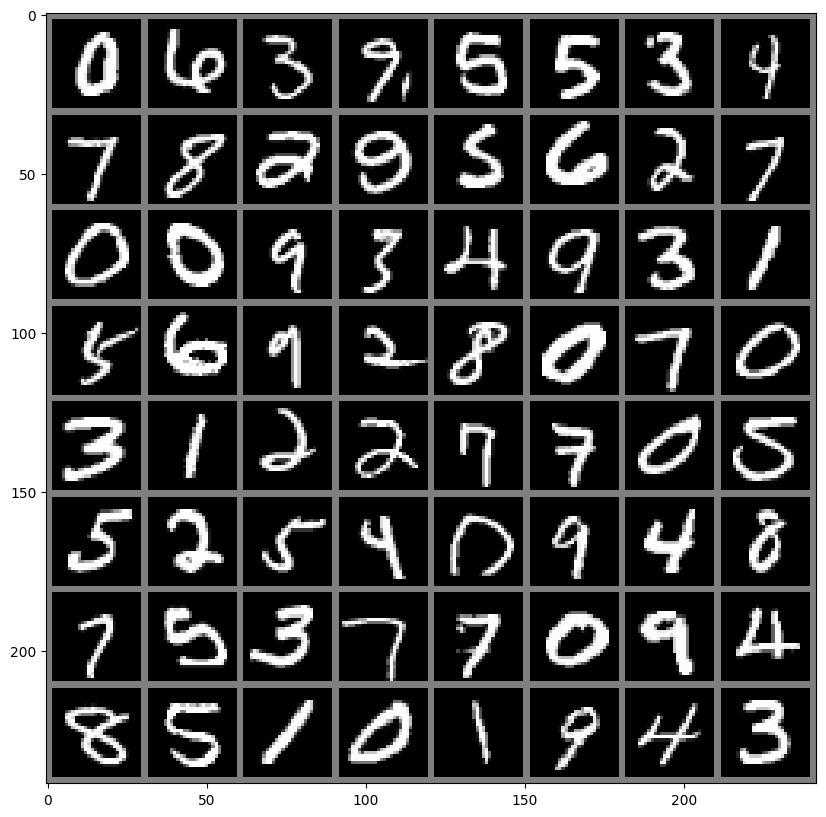

In [9]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

plt.figure(figsize=(10, 10))
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{labels[j]}' for j in range(64)))

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

0 6 3 9 5 5 3 4 7 8 2 9 5 6 2 7 0 0 9 3 4 9 3 1 5 6 9 2 8 0 7 0 3 1 2 2 7 7 0 5 5 2 5 4 0 9 4 8 7 5 3 7 7 0 9 4 8 5 1 0 1 9 4 3


In [11]:
for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  with tqdm(train_loader, unit="batch") as tepoch:
    for images, labels in tepoch:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

100%|██████████| 938/938 [00:19<00:00, 46.97batch/s]


In [13]:
torch.save(model.state_dict(), 'model.pth')

In [14]:
model.load_state_dict(torch.load('model.pth'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

<ipython-input-14-2d01a1ce234c>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))


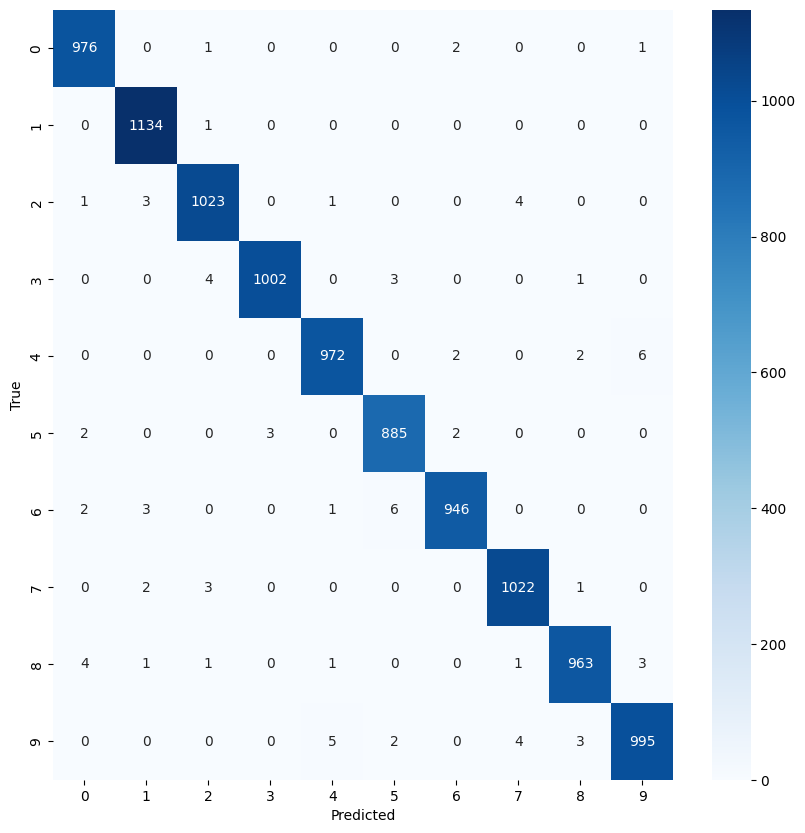

In [15]:
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
